In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import time


import gymnasium as gym


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Environment

In [2]:
#env = gym.make('CartPole-v1', render_mode = 'human')
#observation, info = env.reset()

#for _ in range(100):
#    action = env.action_space.sample()
 #   observation, reward, terminated, truncated, info = env.step(action)
    
  #  if terminated or truncated:
        
   #     observation, info = env.reset()
#env.close()   

# Model


In [3]:
import torch.nn as nn
import torch.nn.functional as F




In [4]:
class net(nn.Module):
    

    def __init__(self):
        super(net, self).__init__()
        self.layer1 = nn.Linear(4, 128) # 4 is length of states vector, 2 is number of actions
        self.layer2 = nn.Linear(128,128)
        self.layer3 = nn.Linear(128, 2)


    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)
    
    def act(self, state): # I assume batch contains only 1 vector, otherwise it should be changed
        y = self(state) # vector of length 2
        return torch.argmax(y).item()
    

In [5]:
class random_model:

    def __init__(self):
        self.x = 1
    
    def act(self, state):
        return np.random.randint(0,2)
        

        
    

# Train

In [6]:
import torch.optim as optim 

In [7]:
class Batch():
    def __init__(self):
        self.l = []
    

    def __len__(self):
        return len(self.l)

    def empty(self):
        self.l = []

    def push(self, element):
        self.l.append(element)
    def __iter__(self):
        return iter(self.l)

    
    




In [28]:
def optimize_batch(model, target_nn, env, optimizer, batch):
    # batch is list of tuples

    #states = torch.stack([t[0] for t in batch.l])
    #predicted = model(states)
    loss = 0.0
    huber_loss = torch.nn.HuberLoss()

    for sample in batch:
        obs_0, a, r, done, obs_1 = sample[0], sample[1], sample[2], sample[3], sample[4]
        predicted = model(obs_0)[a]
        if done:
            target = torch.tensor(r, dtype = torch.float32) 
        else:
            target = r + target_nn(obs_1).max() 
        
        loss += huber_loss(predicted, target)
    loss = loss / len(batch)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
            
            
       





In [29]:
def select_action(policy, game, state, eps):
    
    if np.random.rand() < eps:
        return game.action_space.sample() 
    else:
        with torch.no_grad():
            return policy.act(state)

In [30]:
def train(model, game, optimizer, n_ep = 10000, batch_size = 32, eps = 0.01, gamma = 1.0, target_update = 100):
     
    # gamma is decay rate

    batch = Batch()
    target_nn = net()
    target_nn.load_state_dict(model.state_dict())
    steps = 0 
    for ep in range(n_ep):
        obs_0, info = game.reset()
        obs_0 = torch.tensor(obs_0, dtype = torch.float32)
        duration = 0 # duration of episode
        total_r_ep = 0.0 # total rewards per episode

        flag = False # if termination happens while we fill batch, after optimization step we finish episode.

        while True:

            while len(batch) < batch_size:
                a = select_action(model, game, obs_0, eps)
                obs_1, r, terminated, truncated, info = game.step(a)
                done = terminated or truncated
                obs_1 = torch.tensor(obs_1, dtype = torch.float32)
                sample = (obs_0, a, r, done, obs_1)
                batch.push(sample)

                obs_0 = obs_1.clone()


                if terminated or truncated:
                    obs_0, info = game.reset()
                    obs_0 = torch.tensor(obs_0, dtype = torch.float32)
                    flag = True
                duration += 1 # shesacvlelia
                total_r_ep += r # shesacvlelia
            

            # now we train on batch 
            optimize_batch(model, target_nn, game, optimizer, batch)
            batch.empty()
            if flag:
                if ep%100 == 0:
                    print(f"duration of episode {ep} was {duration}")
                    print(f"total reward for episode {ep} was {total_r_ep}")
                break
            if steps%target_update == 0:
                # copy target
                target_nn.load_state_dict(model.state_dict())
            steps += 1
            




                







In [42]:
env = gym.make('CartPole-v1')
linear = net()


In [43]:
print(linear)

net(
  (layer1): Linear(in_features=4, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=2, bias=True)
)


In [44]:
#sgd = optim.SGD(linear.parameters(), lr = 1e-3)
optimizer = optim.AdamW(linear.parameters(), lr=1e-4, amsgrad=True)

In [45]:
torch.manual_seed(12345)
n_ep = 8000
batch_size = 64

train(linear, env, sgd, n_ep, batch_size)

duration of episode 0 was 128
total reward for episode 0 was 128.0
duration of episode 100 was 64
total reward for episode 100 was 64.0
duration of episode 200 was 64
total reward for episode 200 was 64.0
duration of episode 300 was 128
total reward for episode 300 was 128.0
duration of episode 400 was 64
total reward for episode 400 was 64.0
duration of episode 500 was 64
total reward for episode 500 was 64.0
duration of episode 600 was 64
total reward for episode 600 was 64.0
duration of episode 700 was 64
total reward for episode 700 was 64.0
duration of episode 800 was 64
total reward for episode 800 was 64.0
duration of episode 900 was 64
total reward for episode 900 was 64.0
duration of episode 1000 was 64
total reward for episode 1000 was 64.0
duration of episode 1100 was 64
total reward for episode 1100 was 64.0
duration of episode 1200 was 64
total reward for episode 1200 was 64.0
duration of episode 1300 was 64
total reward for episode 1300 was 64.0
duration of episode 1400 w

In [35]:
def play(model, episodes, show = False, plot = False):

    if show:
        game = gym.make('CartPole-v1', render_mode = "human")
    else:
        game = gym.make('CartPole-v1')
    rewards = []
    for ep in range(episodes):
        obs, info = game.reset()
        obs = torch.from_numpy(obs)
        t_r = 0.0
        duration = 0
        while True:
            time.sleep(0.01)
           # action = model(obs).argmax().item()
            action = model.act(obs)
            obs, reward, terminated, truncated, info = game.step(action)
            obs = torch.from_numpy(obs)
            if terminated or truncated:
                print(f"duration of episode {ep} was {duration}")
                print(f"total reward for episode {ep} was {t_r}")
                obs, info = game.reset()
                break
            duration += 1
            t_r += reward
        rewards.append(t_r)
    plt.plot(rewards)





duration of episode 0 was 76
total reward for episode 0 was 76.0
duration of episode 1 was 53
total reward for episode 1 was 53.0
duration of episode 2 was 41
total reward for episode 2 was 41.0
duration of episode 3 was 10
total reward for episode 3 was 10.0
duration of episode 4 was 10
total reward for episode 4 was 10.0
duration of episode 5 was 21
total reward for episode 5 was 21.0
duration of episode 6 was 54
total reward for episode 6 was 54.0
duration of episode 7 was 9
total reward for episode 7 was 9.0
duration of episode 8 was 34
total reward for episode 8 was 34.0
duration of episode 9 was 46
total reward for episode 9 was 46.0
duration of episode 10 was 25
total reward for episode 10 was 25.0
duration of episode 11 was 17
total reward for episode 11 was 17.0
duration of episode 12 was 26
total reward for episode 12 was 26.0
duration of episode 13 was 47
total reward for episode 13 was 47.0
duration of episode 14 was 37
total reward for episode 14 was 37.0


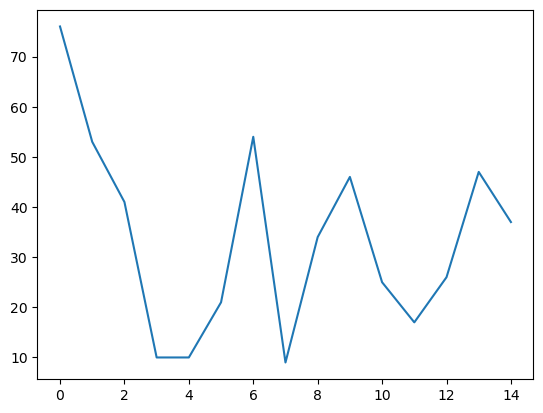

In [49]:
torch.manual_seed(12345)

play(linear, 15, True,True)

duration of episode 0 was 52
total reward for episode 0 was 52.0
duration of episode 1 was 21
total reward for episode 1 was 21.0
duration of episode 2 was 23
total reward for episode 2 was 23.0
duration of episode 3 was 15
total reward for episode 3 was 15.0
duration of episode 4 was 13
total reward for episode 4 was 13.0
duration of episode 5 was 11
total reward for episode 5 was 11.0
duration of episode 6 was 17
total reward for episode 6 was 17.0
duration of episode 7 was 40
total reward for episode 7 was 40.0
duration of episode 8 was 41
total reward for episode 8 was 41.0
duration of episode 9 was 24
total reward for episode 9 was 24.0
duration of episode 10 was 24
total reward for episode 10 was 24.0
duration of episode 11 was 10
total reward for episode 11 was 10.0
duration of episode 12 was 19
total reward for episode 12 was 19.0
duration of episode 13 was 26
total reward for episode 13 was 26.0
duration of episode 14 was 14
total reward for episode 14 was 14.0


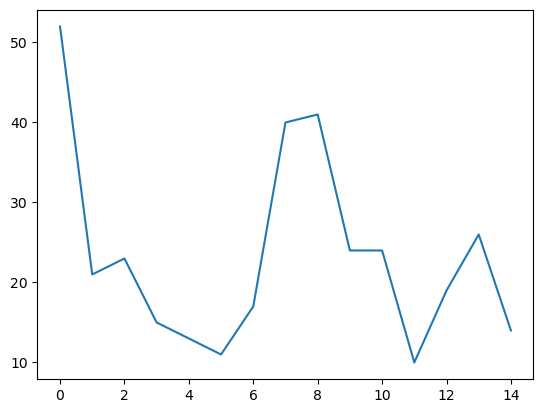

In [48]:
r_m = random_model()
torch.manual_seed(12345)

play(r_m,15,True,True)

In [85]:
t1 = np.array([2.3,1.1])
t2 = np.array([23.3,14.1])
l = []
l.append(t1)
l.append(t2)

In [87]:
t = torch.tensor(l)

In [103]:
a = torch.tensor([1,0])
a

tensor([1, 0])

In [121]:
d1 = True
d2 = False
l = []
l.append(d1)
l.append(d2)

In [124]:
t

tensor([[ 2.3000,  1.1000],
        [23.3000, 14.1000]], dtype=torch.float64)

In [122]:
l = torch.tensor(l)
l

tensor([ True, False])

In [123]:
t.max(dim = 1).values * a


tensor([2.3000, 0.0000], dtype=torch.float64)